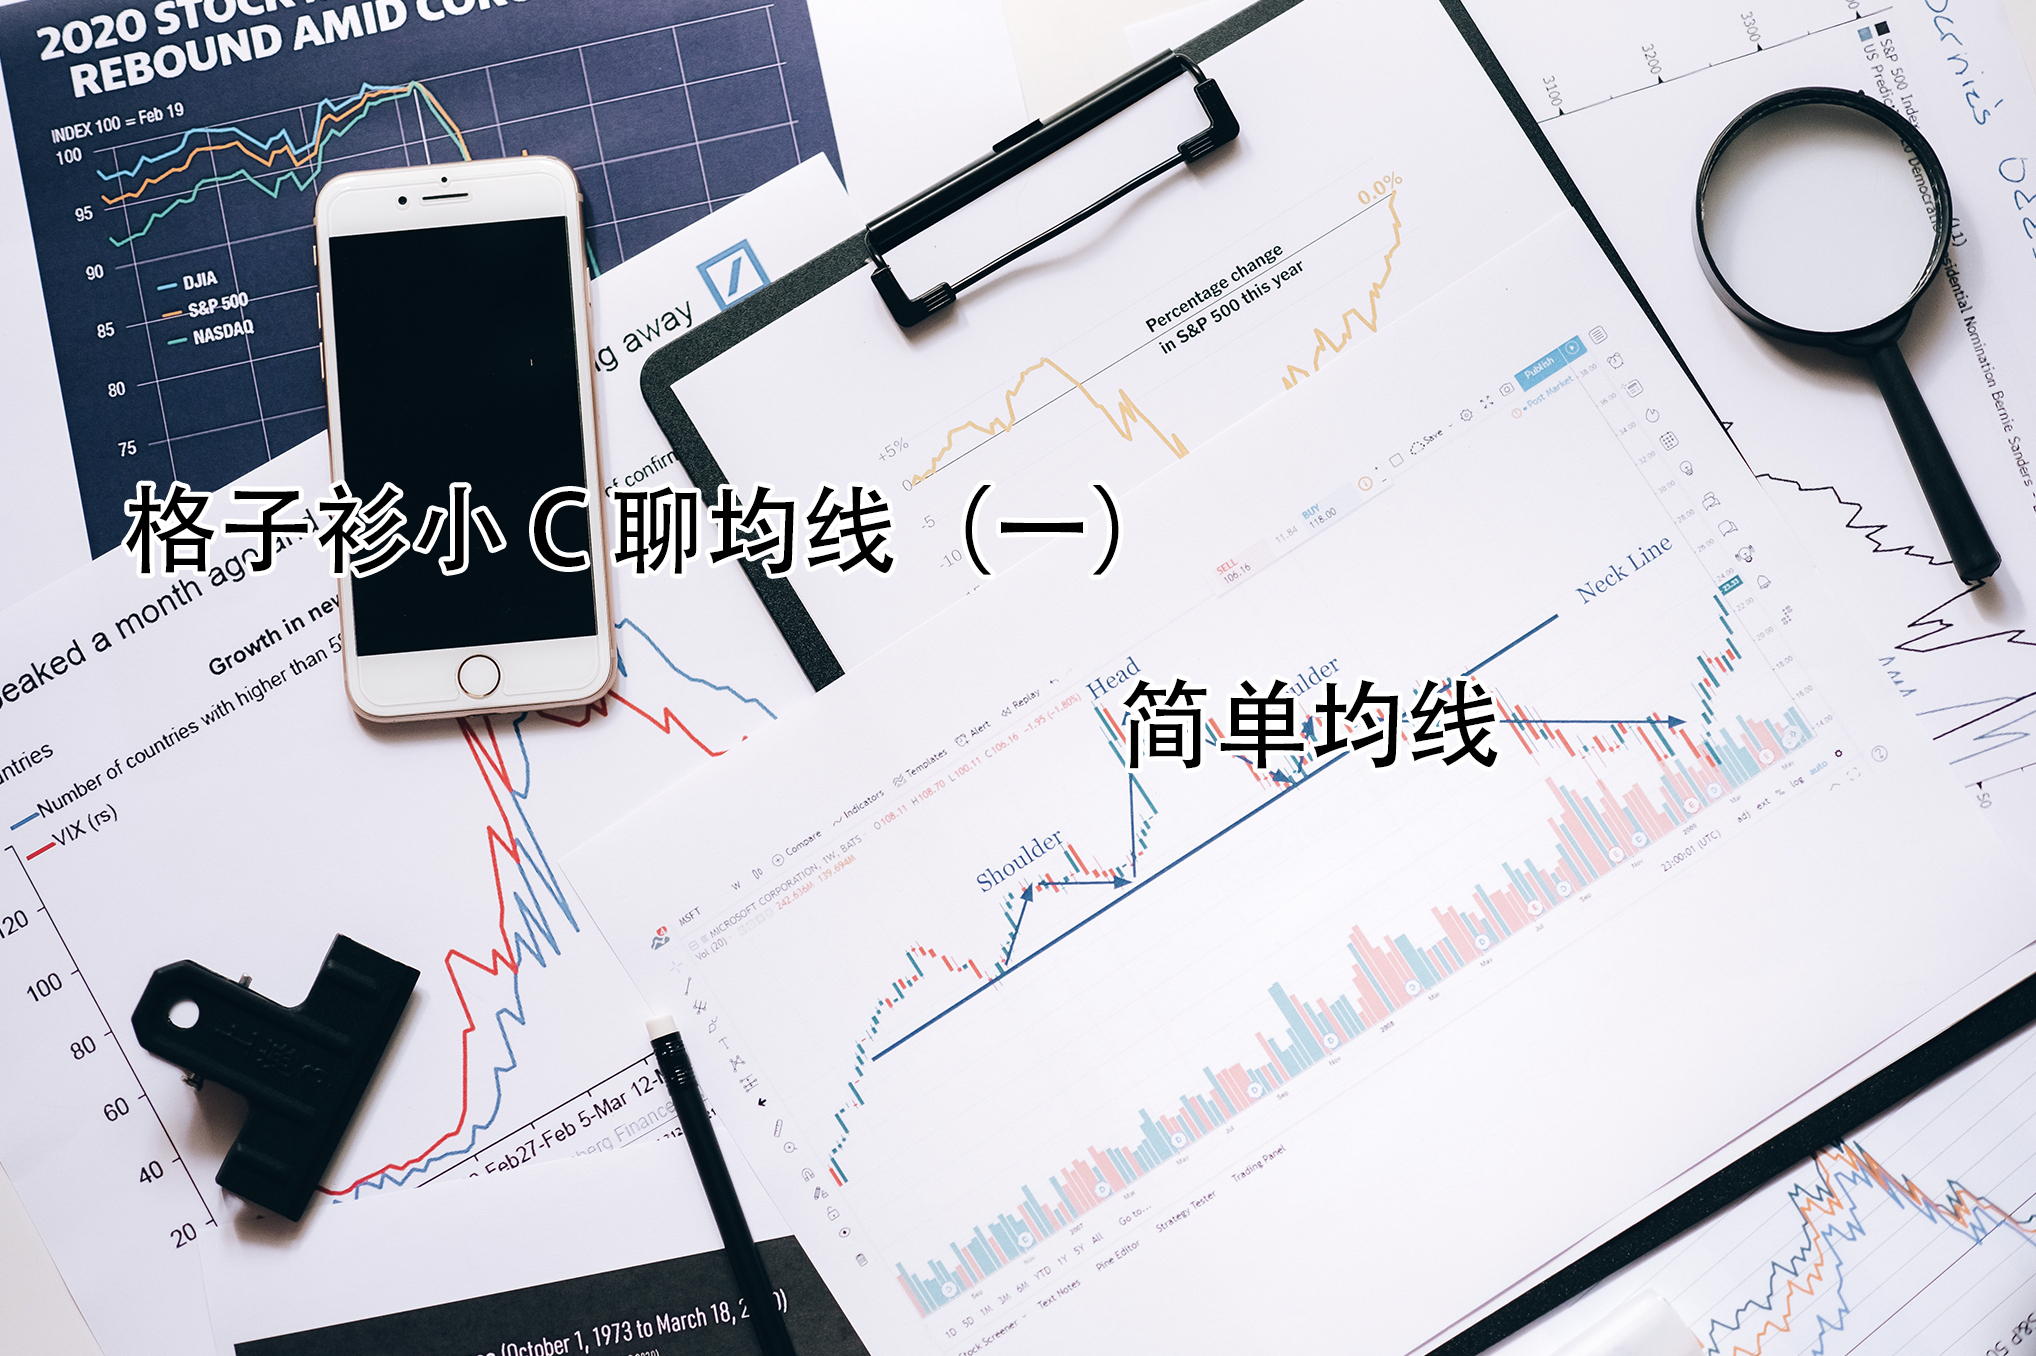

大家好，我是 格子衫小C 。

一个典型的理工男

今天开始，我们一起来研究均线。

均线是最常见的一种指标，在一般交易软件的K线图里都能看到。

在股票论坛里，被讨论得最多的应该也是均线。

均线，顾名思义，就是用各种加权算法算出历史平均价格。

因为均线有明显的滞后性，所以一般也叫 移动平均线 。

也就是 Moving Averages ，简称 MA。

根据平均数算法不同，MA也有很多种，

In [ ]:
import pandas as pd
from datetime import datetime
import trdb2py

isStaticImg = False
width = 960
height = 768

pd.options.display.max_columns = None
pd.options.display.max_rows = None

trdb2cfg = trdb2py.loadConfig('./trdb2.yaml')

In [ ]:
# 具体基金
# asset = 'jrj.510310'
asset = 'jqdata.000300_XSHG|1d'

# 起始时间，0表示从最开始算起
# tsStart = 0
tsStart = int(trdb2py.str2timestamp('2013-05-01', '%Y-%m-%d'))

# 结束时间，-1表示到现在为止
# tsEnd = -1
tsEnd = int(trdb2py.str2timestamp('2020-09-30', '%Y-%m-%d'))

# 初始资金池
paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

# 买入参数，用全部的钱来买入（也就是复利）
paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

# 卖出参数，全部卖出
paramssell = trdb2py.trading2_pb2.SellParams(
    perVolume=1,
)

In [ ]:
# baseline    
s0 = trdb2py.trading2_pb2.Strategy(
    name="normal",
    asset=trdb2py.str2asset(asset),         
)
        
buy0 = trdb2py.trading2_pb2.CtrlCondition(
    name='buyandhold',
)

paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

s0.buy.extend([buy0])
s0.paramsBuy.CopyFrom(paramsbuy)
s0.paramsInit.CopyFrom(paramsinit)        
p0 = trdb2py.trading2_pb2.SimTradingParams(
    assets=[trdb2py.str2asset(asset)],
    startTs=tsStart,
    endTs=tsEnd,
    strategies=[s0],
    title='沪深300指数',
)  

pnlBaseline = trdb2py.simTrading(trdb2cfg, p0)

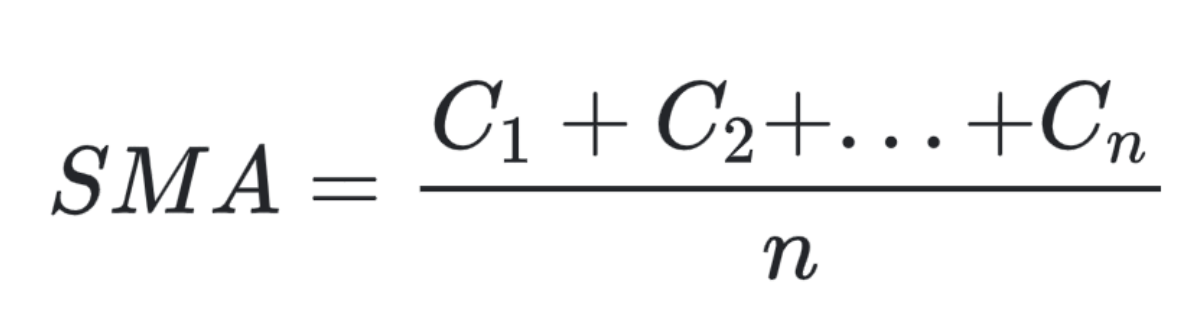

其中，最简单的就是根据算术平均数来计算，一般叫 SMA 。

均线因为n值不一样，会有很多条，

譬如交易软件里经常用到的有5日均线、30日均线、60日均线等。

如果拿日线数据来做均线，就叫5日均线

如果是拿分钟数据，就是 5分钟均线了。

我们实际的看一下均线。

In [ ]:
trdb2py.showPNL(pnlBaseline, toImg=isStaticImg, width=width, height=height)

In [ ]:
ret = trdb2py.getAssetCandles2(trdb2cfg, asset, tsStart, tsEnd, indicators=['sma.2', 'sma.5', 'sma.30', 'sma.60'])
trdb2py.showAssetCandles2('沪深300指数', ret, indicators=['sma.2', 'sma.5', 'sma.30', 'sma.60'], toImg=isStaticImg, width=width, height=height)

1. 越大的均线越平滑。

2. 越大的均线滞后性越明显。

3. 越长的均线越远离实际价格曲线，因此交点也越少。

想法很好，我们做个回测看看。

2-60日均线，价格向上穿过时买入，价格向下穿过时卖出

回测标的是沪深300指数

回测时间是2013年5月到2020年9月

In [ ]:
lstparams = []

# 具体基金
# asset = 'jrj.510310'
asset = 'jqdata.000300_XSHG|1d'

# 起始时间，0表示从最开始算起
# tsStart = 0
tsStart = int(trdb2py.str2timestamp('2013-05-01', '%Y-%m-%d'))

# 结束时间，-1表示到现在为止
# tsEnd = -1
tsEnd = int(trdb2py.str2timestamp('2020-09-30', '%Y-%m-%d'))

for ema in range(2, 61):    
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['upcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    buy1 = trdb2py.trading2_pb2.CtrlCondition(
        name='waittostart',
        vals=[ema],
    )    
            
    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['downcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0, buy1])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell) 
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='sma.{}'.format(ema),
    ))
 
lstpnlmix = trdb2py.simTradings(trdb2cfg, lstparams, ignoreTotalReturn=2.3)

In [ ]:
trdb2py.showPNLs(lstpnlmix + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [ ]:
dfpnl = trdb2py.buildPNLReport(lstpnlmix + [pnlBaseline])

dfpnl[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

In [ ]:
lstparams = []

lstems = [2, 3, 16, 35, 41, 42, 43, 60]

# 具体基金
# asset = 'jrj.510310'
asset = 'jqdata.000300_XSHG|1d'

# 起始时间，0表示从最开始算起
# tsStart = 0
tsStart = int(trdb2py.str2timestamp('2013-05-01', '%Y-%m-%d'))

# 结束时间，-1表示到现在为止
# tsEnd = -1
tsEnd = int(trdb2py.str2timestamp('2020-09-30', '%Y-%m-%d'))

for ema in lstems:    
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['upcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    buy1 = trdb2py.trading2_pb2.CtrlCondition(
        name='waittostart',
        vals=[ema],
    )    
            
    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['downcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0, buy1])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell) 
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='sma.{}'.format(ema),
    ))
 
lstpnlmix1 = trdb2py.simTradings(trdb2cfg, lstparams, ignoreTotalReturn=2.3)

In [ ]:
trdb2py.showPNLs(lstpnlmix1 + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

接下来，我们把时间拉长看看复测结果。

把时间放大到2005年-2020年，一共15年

中间经历了2轮牛市。

In [ ]:
# lstems = [2, 42, 60]
# 起始时间，0表示从最开始算起
tsStart = 0
# tsStart = int(trdb2py.str2timestamp('2013-05-01', '%Y-%m-%d'))

# 结束时间，-1表示到现在为止
tsEnd = -1
# tsEnd = int(trdb2py.str2timestamp('2020-09-30', '%Y-%m-%d'))

# baseline    
s0 = trdb2py.trading2_pb2.Strategy(
    name="normal",
    asset=trdb2py.str2asset(asset),         
)
        
buy0 = trdb2py.trading2_pb2.CtrlCondition(
    name='buyandhold',
)

paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

s0.buy.extend([buy0])
s0.paramsBuy.CopyFrom(paramsbuy)
s0.paramsInit.CopyFrom(paramsinit)        
p0 = trdb2py.trading2_pb2.SimTradingParams(
    assets=[trdb2py.str2asset(asset)],
    startTs=tsStart,
    endTs=tsEnd,
    strategies=[s0],
    title='baseline',
)  

pnlBaselineF = trdb2py.simTrading(trdb2cfg, p0)

In [ ]:
trdb2py.showPNL(pnlBaselineF, toImg=isStaticImg, width=width, height=height)

In [ ]:
lstparams = []

lstems = [2, 3, 16, 35, 41, 42, 43, 60]
# 起始时间，0表示从最开始算起
tsStart = 0
# tsStart = int(trdb2py.str2timestamp('2013-05-01', '%Y-%m-%d'))

# 结束时间，-1表示到现在为止
tsEnd = -1
tsEnd = int(trdb2py.str2timestamp('2020-12-31', '%Y-%m-%d'))

for ema in lstems:    
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['upcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    buy1 = trdb2py.trading2_pb2.CtrlCondition(
        name='waittostart',
        vals=[ema],
    )    
            
    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='indicatorsp',
        operators=['downcross'],
        strVals=['ta-sma.{}'.format(ema)],
    )
    
    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0, buy1])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell) 
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='sma.{}'.format(ema),
    ))
 
lstpnlmix = trdb2py.simTradings(trdb2cfg, lstparams, ignoreTotalReturn=2.3)

In [ ]:
dfpnl = trdb2py.buildPNLReport(lstpnlmix + [pnlBaselineF])

dfpnl[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

In [ ]:
trdb2py.showPNLs(lstpnlmix + [pnlBaselineF], toImg=isStaticImg, width=width, height=height)

对于均线，今天我们可以有以下结论：

1. 过小的均线意义不大，纯博运气。

2. 过大的均线意义不大，滞后太严重。该有的上涨没吃到，该避开的下跌也没避开。

3. 均线不适用于突然的剧烈价格变化。譬如2020年初疫情导致的突然下跌。

4. 合适的均线可以吃掉大的上涨区间，避开大的下跌区间。

5. 均线不适用于震荡期。震荡期里，均线的收益几乎都是收窄的。

6. 均线和价格处于同一数值区间，可以用 “穿过” 或 “在上方或下方” 的判断方法来判断。

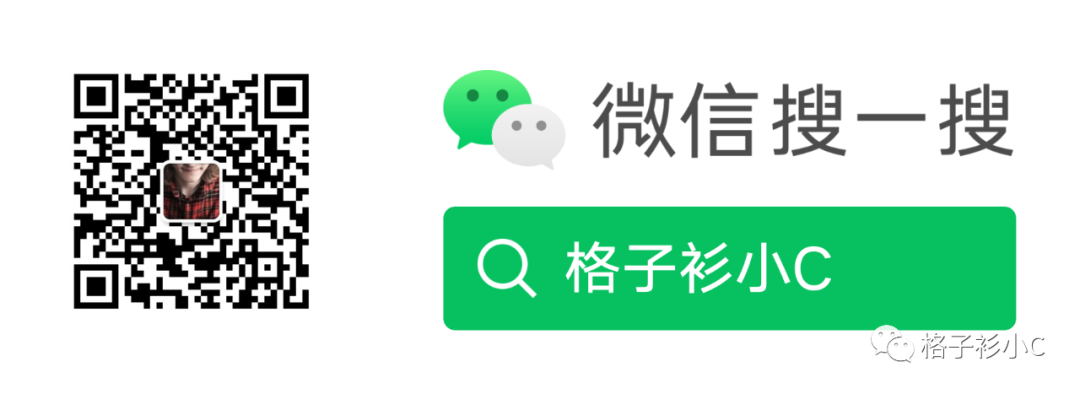